In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)


class AffectNetDatasetForSupCon(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 transform,
                 return_labels=True,
                 crop=False,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.crop = crop
        self.transform = transform
        self.return_labels = return_labels
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        img1 = self.transform(img)
        img2 = self.transform(img)
        if self.return_labels:
            target = torch.tensor(self.df['expression'][idx])
            return (img1.float(), img2.float()), target
        else:
            return img1.float(), img2.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def contrastive_collate_fn(examples):
    # imgs, targets = zip(*examples)
    imgs1, imgs2 = zip(*examples)
    imgs1 = torch.stack(imgs1)
    imgs2 = torch.stack(imgs2)
    pixel_values = torch.cat([imgs1, imgs2])
    return {'pixel_values': pixel_values}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/training.csv',
                                                images_root,
                                                crop=False,
                                                transform=supcon_transform,
                                                return_labels=False,
                                                invalid_files=train_invalid_files)

print('contrastive:', len(contrastive_dataset))

contrastive: 320739


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(contrastive_dataset, collate_fn=contrastive_collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])


In [9]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SimCLRTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        imgs = inputs.get('pixel_values')
        bsz = int(imgs.shape[0] / 2)
        outputs = model(pixel_values=imgs, output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features)
        return (loss, features) if return_outputs else loss

In [10]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=128,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', group='affectnet-contrastive', name='simCLR-pretrain-valaro')

contrastive_args = TrainingArguments(
    f"affectnet-contrastive",
    save_strategy='epoch',
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=1000,
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [12]:
trainer = SimCLRTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=contrastive_collate_fn,
    tokenizer=feature_extractor,
)

In [13]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 1000/100235 [12:03<20:05:39,  1.37it/s]

{'loss': 0.3513, 'learning_rate': 9.900234449044745e-07, 'epoch': 0.05}


  2%|▏         | 2000/100235 [23:57<18:54:32,  1.44it/s]

{'loss': 0.1653, 'learning_rate': 9.80046889808949e-07, 'epoch': 0.1}


  3%|▎         | 3000/100235 [35:49<18:29:58,  1.46it/s]

{'loss': 0.1087, 'learning_rate': 9.700703347134235e-07, 'epoch': 0.15}


  4%|▍         | 4000/100235 [47:44<18:47:50,  1.42it/s]

{'loss': 0.0876, 'learning_rate': 9.60093779617898e-07, 'epoch': 0.2}


  5%|▍         | 5000/100235 [59:36<18:23:21,  1.44it/s]

{'loss': 0.0636, 'learning_rate': 9.501172245223724e-07, 'epoch': 0.25}


  6%|▌         | 6000/100235 [1:11:27<19:01:34,  1.38it/s]

{'loss': 0.051, 'learning_rate': 9.401406694268468e-07, 'epoch': 0.3}


  7%|▋         | 7000/100235 [1:23:20<18:35:21,  1.39it/s]

{'loss': 0.0412, 'learning_rate': 9.301641143313213e-07, 'epoch': 0.35}


  8%|▊         | 8000/100235 [1:35:13<18:10:59,  1.41it/s]

{'loss': 0.0374, 'learning_rate': 9.201875592357958e-07, 'epoch': 0.4}


  9%|▉         | 9000/100235 [1:47:07<17:26:40,  1.45it/s]

{'loss': 0.03, 'learning_rate': 9.102110041402703e-07, 'epoch': 0.45}


 10%|▉         | 10000/100235 [1:59:04<17:52:06,  1.40it/s]

{'loss': 0.0247, 'learning_rate': 9.002344490447447e-07, 'epoch': 0.5}


 11%|█         | 11000/100235 [2:11:03<17:45:55,  1.40it/s]

{'loss': 0.022, 'learning_rate': 8.902578939492192e-07, 'epoch': 0.55}


 12%|█▏        | 12000/100235 [2:23:03<17:20:35,  1.41it/s]

{'loss': 0.0242, 'learning_rate': 8.802813388536938e-07, 'epoch': 0.6}


 13%|█▎        | 13000/100235 [2:35:05<17:16:01,  1.40it/s]

{'loss': 0.0214, 'learning_rate': 8.703047837581683e-07, 'epoch': 0.65}


 14%|█▍        | 14000/100235 [2:47:04<17:11:38,  1.39it/s]

{'loss': 0.0184, 'learning_rate': 8.603282286626427e-07, 'epoch': 0.7}


 15%|█▍        | 15000/100235 [2:59:01<16:45:46,  1.41it/s]

{'loss': 0.0146, 'learning_rate': 8.503516735671172e-07, 'epoch': 0.75}


 16%|█▌        | 16000/100235 [3:10:58<16:46:04,  1.40it/s]

{'loss': 0.0161, 'learning_rate': 8.403751184715917e-07, 'epoch': 0.8}


 17%|█▋        | 17000/100235 [3:22:56<16:21:44,  1.41it/s]

{'loss': 0.0136, 'learning_rate': 8.303985633760662e-07, 'epoch': 0.85}


 18%|█▊        | 18000/100235 [3:34:53<15:46:05,  1.45it/s]

{'loss': 0.012, 'learning_rate': 8.204220082805406e-07, 'epoch': 0.9}


 19%|█▉        | 19000/100235 [3:46:49<16:43:30,  1.35it/s]

{'loss': 0.0123, 'learning_rate': 8.104454531850152e-07, 'epoch': 0.95}


 20%|█▉        | 20000/100235 [3:58:46<16:05:08,  1.39it/s]

{'loss': 0.0089, 'learning_rate': 8.004688980894897e-07, 'epoch': 1.0}


 21%|██        | 21000/100235 [4:10:41<15:15:02,  1.44it/s]

{'loss': 0.0092, 'learning_rate': 7.904923429939642e-07, 'epoch': 1.05}


 22%|██▏       | 22000/100235 [4:22:32<15:19:58,  1.42it/s]

{'loss': 0.0103, 'learning_rate': 7.805157878984386e-07, 'epoch': 1.1}


 23%|██▎       | 23000/100235 [4:34:21<15:23:07,  1.39it/s]

{'loss': 0.0097, 'learning_rate': 7.705392328029131e-07, 'epoch': 1.15}


 24%|██▍       | 24000/100235 [4:46:13<15:07:34,  1.40it/s]

{'loss': 0.0103, 'learning_rate': 7.605626777073876e-07, 'epoch': 1.2}


 25%|██▍       | 25000/100235 [4:58:04<14:47:06,  1.41it/s]

{'loss': 0.0078, 'learning_rate': 7.505861226118621e-07, 'epoch': 1.25}


 26%|██▌       | 26000/100235 [5:09:57<15:36:13,  1.32it/s]

{'loss': 0.0093, 'learning_rate': 7.406095675163366e-07, 'epoch': 1.3}


 27%|██▋       | 27000/100235 [5:21:51<14:21:45,  1.42it/s]

{'loss': 0.0076, 'learning_rate': 7.306330124208111e-07, 'epoch': 1.35}


 28%|██▊       | 28000/100235 [5:33:48<13:57:25,  1.44it/s]

{'loss': 0.0081, 'learning_rate': 7.206564573252856e-07, 'epoch': 1.4}


 29%|██▉       | 29000/100235 [5:45:41<14:09:41,  1.40it/s]

{'loss': 0.0079, 'learning_rate': 7.106799022297601e-07, 'epoch': 1.45}


 30%|██▉       | 30000/100235 [5:57:34<14:04:27,  1.39it/s]

{'loss': 0.0095, 'learning_rate': 7.007033471342345e-07, 'epoch': 1.5}


 31%|███       | 31000/100235 [6:09:30<13:43:53,  1.40it/s]

{'loss': 0.0063, 'learning_rate': 6.90726792038709e-07, 'epoch': 1.55}


 32%|███▏      | 32000/100235 [6:21:25<13:22:33,  1.42it/s]

{'loss': 0.0074, 'learning_rate': 6.807502369431835e-07, 'epoch': 1.6}


 33%|███▎      | 33000/100235 [6:33:20<12:56:48,  1.44it/s]

{'loss': 0.0076, 'learning_rate': 6.707736818476579e-07, 'epoch': 1.65}


 34%|███▍      | 34000/100235 [6:45:16<12:53:02,  1.43it/s]

{'loss': 0.0057, 'learning_rate': 6.607971267521325e-07, 'epoch': 1.7}


 35%|███▍      | 35000/100235 [6:57:11<12:25:40,  1.46it/s]

{'loss': 0.0054, 'learning_rate': 6.50820571656607e-07, 'epoch': 1.75}


 36%|███▌      | 36000/100235 [7:09:09<12:40:19,  1.41it/s]

{'loss': 0.0069, 'learning_rate': 6.408440165610815e-07, 'epoch': 1.8}


 37%|███▋      | 37000/100235 [7:21:08<12:26:29,  1.41it/s]

{'loss': 0.0052, 'learning_rate': 6.308674614655559e-07, 'epoch': 1.85}


 38%|███▊      | 38000/100235 [7:33:05<12:44:20,  1.36it/s]

{'loss': 0.0055, 'learning_rate': 6.208909063700304e-07, 'epoch': 1.9}


 39%|███▉      | 39000/100235 [7:45:05<11:54:36,  1.43it/s]

{'loss': 0.0061, 'learning_rate': 6.109143512745049e-07, 'epoch': 1.95}


 40%|███▉      | 40000/100235 [7:57:05<11:42:59,  1.43it/s]

{'loss': 0.0043, 'learning_rate': 6.009377961789794e-07, 'epoch': 2.0}


 41%|████      | 41000/100235 [8:08:59<11:42:03,  1.41it/s]

{'loss': 0.0046, 'learning_rate': 5.909612410834539e-07, 'epoch': 2.05}


 42%|████▏     | 42000/100235 [8:20:53<11:21:22,  1.42it/s]

{'loss': 0.0049, 'learning_rate': 5.809846859879284e-07, 'epoch': 2.1}


 43%|████▎     | 43000/100235 [8:32:47<11:39:01,  1.36it/s]

{'loss': 0.0048, 'learning_rate': 5.710081308924029e-07, 'epoch': 2.14}


 44%|████▍     | 44000/100235 [8:44:43<11:24:57,  1.37it/s]

{'loss': 0.0045, 'learning_rate': 5.610315757968774e-07, 'epoch': 2.19}


 45%|████▍     | 45000/100235 [8:56:37<11:10:22,  1.37it/s]

{'loss': 0.0042, 'learning_rate': 5.510550207013518e-07, 'epoch': 2.24}


 46%|████▌     | 46000/100235 [9:08:32<10:40:22,  1.41it/s]

{'loss': 0.0056, 'learning_rate': 5.410784656058262e-07, 'epoch': 2.29}


 47%|████▋     | 47000/100235 [9:20:26<10:45:10,  1.38it/s]

{'loss': 0.0038, 'learning_rate': 5.311019105103007e-07, 'epoch': 2.34}


 48%|████▊     | 48000/100235 [9:32:20<9:57:41,  1.46it/s] 

{'loss': 0.0047, 'learning_rate': 5.211253554147752e-07, 'epoch': 2.39}


 49%|████▉     | 49000/100235 [9:44:15<10:51:22,  1.31it/s]

{'loss': 0.0041, 'learning_rate': 5.111488003192497e-07, 'epoch': 2.44}


 50%|████▉     | 50000/100235 [9:56:10<9:40:46,  1.44it/s] 

{'loss': 0.0043, 'learning_rate': 5.011722452237242e-07, 'epoch': 2.49}


 51%|█████     | 51000/100235 [10:08:05<9:26:00,  1.45it/s] 

{'loss': 0.0039, 'learning_rate': 4.911956901281987e-07, 'epoch': 2.54}


 52%|█████▏    | 52000/100235 [10:19:58<9:32:44,  1.40it/s] 

{'loss': 0.0047, 'learning_rate': 4.812191350326732e-07, 'epoch': 2.59}


 53%|█████▎    | 53000/100235 [10:31:53<9:13:03,  1.42it/s] 

{'loss': 0.0041, 'learning_rate': 4.712425799371477e-07, 'epoch': 2.64}


 54%|█████▍    | 54000/100235 [10:43:50<8:56:19,  1.44it/s] 

{'loss': 0.0045, 'learning_rate': 4.612660248416222e-07, 'epoch': 2.69}


 55%|█████▍    | 55000/100235 [10:55:49<9:07:45,  1.38it/s]

{'loss': 0.0046, 'learning_rate': 4.512894697460967e-07, 'epoch': 2.74}


 56%|█████▌    | 56000/100235 [11:07:47<8:38:17,  1.42it/s] 

{'loss': 0.0037, 'learning_rate': 4.4131291465057113e-07, 'epoch': 2.79}


 57%|█████▋    | 57000/100235 [11:19:48<8:58:13,  1.34it/s] 

{'loss': 0.004, 'learning_rate': 4.313363595550456e-07, 'epoch': 2.84}


 58%|█████▊    | 58000/100235 [11:31:48<8:30:26,  1.38it/s]

{'loss': 0.005, 'learning_rate': 4.213598044595201e-07, 'epoch': 2.89}


 59%|█████▉    | 59000/100235 [11:43:48<8:17:09,  1.38it/s]

{'loss': 0.0037, 'learning_rate': 4.113832493639946e-07, 'epoch': 2.94}


 60%|█████▉    | 60000/100235 [11:55:48<8:07:30,  1.38it/s]

{'loss': 0.0038, 'learning_rate': 4.0140669426846907e-07, 'epoch': 2.99}


 61%|██████    | 61000/100235 [12:07:44<7:42:48,  1.41it/s] 

{'loss': 0.0036, 'learning_rate': 3.9143013917294357e-07, 'epoch': 3.04}


 62%|██████▏   | 62000/100235 [12:19:37<7:38:41,  1.39it/s]

{'loss': 0.0029, 'learning_rate': 3.8145358407741807e-07, 'epoch': 3.09}


 63%|██████▎   | 63000/100235 [12:31:29<7:15:01,  1.43it/s]

{'loss': 0.0031, 'learning_rate': 3.714770289818925e-07, 'epoch': 3.14}


 64%|██████▍   | 64000/100235 [12:43:21<7:22:20,  1.37it/s]

{'loss': 0.004, 'learning_rate': 3.61500473886367e-07, 'epoch': 3.19}


 65%|██████▍   | 65000/100235 [12:55:18<6:55:54,  1.41it/s]

{'loss': 0.0039, 'learning_rate': 3.515239187908415e-07, 'epoch': 3.24}


 66%|██████▌   | 66000/100235 [13:07:10<6:39:29,  1.43it/s]

{'loss': 0.0041, 'learning_rate': 3.41547363695316e-07, 'epoch': 3.29}


 67%|██████▋   | 67000/100235 [13:19:04<6:31:21,  1.42it/s]

{'loss': 0.0038, 'learning_rate': 3.3157080859979045e-07, 'epoch': 3.34}


 68%|██████▊   | 68000/100235 [13:30:57<6:39:05,  1.35it/s]

{'loss': 0.0037, 'learning_rate': 3.2159425350426495e-07, 'epoch': 3.39}


 69%|██████▉   | 69000/100235 [13:42:51<6:24:47,  1.35it/s]

{'loss': 0.0052, 'learning_rate': 3.1161769840873945e-07, 'epoch': 3.44}


 70%|██████▉   | 70000/100235 [13:54:43<5:59:33,  1.40it/s]

{'loss': 0.0037, 'learning_rate': 3.0164114331321395e-07, 'epoch': 3.49}


 71%|███████   | 71000/100235 [14:06:39<5:40:00,  1.43it/s]

{'loss': 0.0025, 'learning_rate': 2.916645882176884e-07, 'epoch': 3.54}


 72%|███████▏  | 72000/100235 [14:18:33<5:26:56,  1.44it/s]

{'loss': 0.0026, 'learning_rate': 2.816880331221629e-07, 'epoch': 3.59}


 73%|███████▎  | 73000/100235 [14:30:28<5:36:33,  1.35it/s]

{'loss': 0.0029, 'learning_rate': 2.717114780266374e-07, 'epoch': 3.64}


 74%|███████▍  | 74000/100235 [14:42:24<5:14:17,  1.39it/s]

{'loss': 0.0034, 'learning_rate': 2.617349229311119e-07, 'epoch': 3.69}


 75%|███████▍  | 75000/100235 [14:54:19<5:04:10,  1.38it/s]

{'loss': 0.0031, 'learning_rate': 2.5175836783558633e-07, 'epoch': 3.74}


 76%|███████▌  | 76000/100235 [15:06:17<4:44:50,  1.42it/s]

{'loss': 0.003, 'learning_rate': 2.4178181274006083e-07, 'epoch': 3.79}


 77%|███████▋  | 77000/100235 [15:18:13<4:33:00,  1.42it/s]

{'loss': 0.0025, 'learning_rate': 2.3180525764453533e-07, 'epoch': 3.84}


 78%|███████▊  | 78000/100235 [15:30:11<4:29:45,  1.37it/s]

{'loss': 0.0025, 'learning_rate': 2.2182870254900983e-07, 'epoch': 3.89}


 79%|███████▉  | 79000/100235 [15:42:10<4:10:42,  1.41it/s]

{'loss': 0.0033, 'learning_rate': 2.118521474534843e-07, 'epoch': 3.94}


 80%|███████▉  | 80000/100235 [15:54:09<3:56:31,  1.43it/s]

{'loss': 0.0036, 'learning_rate': 2.0187559235795877e-07, 'epoch': 3.99}


 81%|████████  | 81000/100235 [16:06:06<3:43:48,  1.43it/s]

{'loss': 0.0032, 'learning_rate': 1.9189903726243327e-07, 'epoch': 4.04}


 82%|████████▏ | 82000/100235 [16:18:00<3:29:13,  1.45it/s]

{'loss': 0.0035, 'learning_rate': 1.8192248216690774e-07, 'epoch': 4.09}


 83%|████████▎ | 83000/100235 [16:29:52<3:15:46,  1.47it/s]

{'loss': 0.0024, 'learning_rate': 1.7194592707138224e-07, 'epoch': 4.14}


 84%|████████▍ | 84000/100235 [16:41:43<3:12:59,  1.40it/s]

{'loss': 0.0033, 'learning_rate': 1.6196937197585671e-07, 'epoch': 4.19}


 85%|████████▍ | 85000/100235 [16:53:38<2:57:42,  1.43it/s]

{'loss': 0.0039, 'learning_rate': 1.519928168803312e-07, 'epoch': 4.24}


 86%|████████▌ | 86000/100235 [17:05:31<2:48:52,  1.40it/s]

{'loss': 0.0035, 'learning_rate': 1.4201626178480568e-07, 'epoch': 4.29}


 87%|████████▋ | 87000/100235 [17:17:37<2:41:31,  1.37it/s]

{'loss': 0.0051, 'learning_rate': 1.3203970668928018e-07, 'epoch': 4.34}


 88%|████████▊ | 88000/100235 [17:29:33<2:25:04,  1.41it/s]

{'loss': 0.0032, 'learning_rate': 1.2206315159375468e-07, 'epoch': 4.39}


 89%|████████▉ | 89000/100235 [17:41:29<2:21:08,  1.33it/s]

{'loss': 0.0025, 'learning_rate': 1.1208659649822915e-07, 'epoch': 4.44}


 90%|████████▉ | 90000/100235 [17:53:22<2:03:07,  1.39it/s]

{'loss': 0.004, 'learning_rate': 1.0211004140270364e-07, 'epoch': 4.49}


 91%|█████████ | 91000/100235 [18:05:20<1:52:26,  1.37it/s]

{'loss': 0.0034, 'learning_rate': 9.213348630717812e-08, 'epoch': 4.54}


 92%|█████████▏| 92000/100235 [18:17:15<1:34:55,  1.45it/s]

{'loss': 0.0038, 'learning_rate': 8.215693121165261e-08, 'epoch': 4.59}


 93%|█████████▎| 93000/100235 [18:29:11<1:27:27,  1.38it/s]

{'loss': 0.0032, 'learning_rate': 7.21803761161271e-08, 'epoch': 4.64}


 94%|█████████▍| 94000/100235 [18:41:09<1:12:49,  1.43it/s]

{'loss': 0.0035, 'learning_rate': 6.220382102060158e-08, 'epoch': 4.69}


 95%|█████████▍| 95000/100235 [18:53:07<1:03:47,  1.37it/s]

{'loss': 0.0026, 'learning_rate': 5.222726592507607e-08, 'epoch': 4.74}


 96%|█████████▌| 96000/100235 [19:05:06<49:50,  1.42it/s]  

{'loss': 0.0028, 'learning_rate': 4.225071082955056e-08, 'epoch': 4.79}


 97%|█████████▋| 97000/100235 [19:17:06<38:40,  1.39it/s]

{'loss': 0.003, 'learning_rate': 3.227415573402504e-08, 'epoch': 4.84}


 98%|█████████▊| 98000/100235 [19:29:06<27:38,  1.35it/s]

{'loss': 0.0025, 'learning_rate': 2.2297600638499524e-08, 'epoch': 4.89}


 99%|█████████▉| 99000/100235 [19:41:06<15:08,  1.36it/s]

{'loss': 0.0035, 'learning_rate': 1.232104554297401e-08, 'epoch': 4.94}


100%|█████████▉| 100000/100235 [19:53:07<02:45,  1.42it/s]

{'loss': 0.0033, 'learning_rate': 2.344490447448496e-09, 'epoch': 4.99}


100%|██████████| 100235/100235 [19:55:56<00:00,  1.40it/s]

{'train_runtime': 71756.9373, 'train_samples_per_second': 22.349, 'train_steps_per_second': 1.397, 'train_loss': 0.014934181972008343, 'epoch': 5.0}


TrainOutput(global_step=100235, training_loss=0.014934181972008343, metrics={'train_runtime': 71756.9373, 'train_samples_per_second': 22.349, 'train_steps_per_second': 1.397, 'train_loss': 0.014934181972008343, 'epoch': 5.0})

In [15]:
trainer.save_state()
trainer.save_model()

In [16]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [17]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt',
            8: 'None'}

In [18]:
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()


In [20]:
transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor(),
                     normalize])

val_label_dataset = AffectNetDataset('../Affectnet/validation.csv',
                                     images_root,
                                     transform=transform,
                                     invalid_files=val_invalid_files)

100%|██████████| 4500/4500 [00:58<00:00, 77.34it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_2987493/2325597237.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


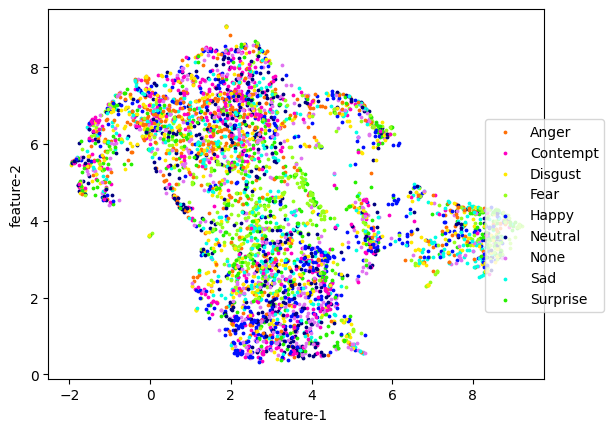

In [21]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 10)

In [22]:
wandb.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,5.0
train/global_step,100235
